In [1]:
import csv
import numpy as np
file_name='Conectomics_MIRIAM_V2_Clean_2021_06_10.csv'
in_file =open(file_name,"r")

lines = in_file.readlines()
in_file.close()
N=1001
m=42
A=np.zeros((N,m))
mask=np.zeros((N,m))
i=-1
for line in lines:
    ln=line.split(',')
    i+=1
    j=-1
    for l in ln:
        j+=1
        if not (l=='' or l== '\n'):
            mask[i,j]=1
            #print(i)
            #print(j)
            #print(l)
            A[i,j]=float(l)


mu=sum(A)/sum(mask)
x2=sum(A*A)/sum(mask)
sig=x2-mu*mu
#m=m-7
#A=(A-mu)/sig
#remove={41, 10, 11, 12, 15, 19, 25}
#contain=list(set(range(1,43))-remove)
#print(contain)
val=(A-mu)/np.sqrt(sig)

In [36]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(val)#[:,0:28])
print(pca.explained_variance_ratio_)

[0.2165261  0.08078071 0.06631141 0.06110756 0.04889417 0.04478783
 0.0384416  0.03627049 0.03265536 0.03103511]


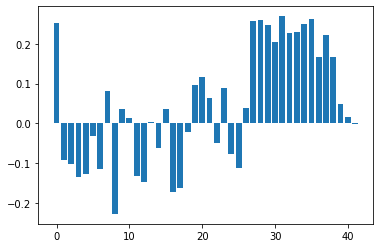

In [37]:
a=pca.components_
import matplotlib.pyplot as plt
plt.bar(range(42),a[0,:])
plt.show()

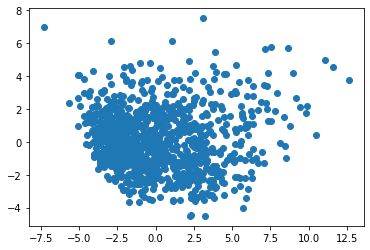

In [40]:
V=val[:,0:42].dot(np.transpose(a))
plt.scatter(V[:,0],V[:,1])
plt.show()

13


13

NameError: name 'PCA' is not defined

In [1]:
from sklearn.datasets import load_wine
data = load_wine()
X=(data['data'])
print(len(X[0,:])) 

import numpy as np
mu=np.mean(X,axis=0)
len(mu)
import numpy as np 
X=(X-mu)/np.std(X,axis=0)
print(np.std(X,axis=0))

13
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [43]:
def mat(sig,W,X):
    #W=W*12/sum(W)
    W=W*sig
    Xs=X*abs(W)#**0.5
    A=Xs.dot(np.transpose(X))
    A=np.exp(2*A-np.diag(A)-np.diag(A)[:,None])
    #A=A/(1+A)
    np.fill_diagonal(A,0)
    return A

def mat2(W,X):
    Xs=X/abs(W)#**0.5
    A=Xs.dot(np.transpose(Xs))
    A=np.exp(2*A-np.diag(A)-np.diag(A)[:,None])
    #A=A/(1+A)
    np.fill_diagonal(A,0)
    return A

def loss(W,X,U):
    A=mat(W,X)
    L=-np.sum(np.log(sum(A.dot(U)))+sum(np.log(sum(A))))
    return L

def dloss1(A,U):
    Del=U.dot(np.transpose(U))
    dL=(2*Del-1)
    return dL

def dloss4(A,U):
    A2=A+0
    np.fill_diagonal(A2,0)
    Del=U.dot(np.transpose(U))
    dL=Del/sum(A2*Del)[:,None]-1/sum(A2)[:,None]
    return dL

def dloss2(A,U):
    A=A+1
    Del=U.dot(np.transpose(U))
    dL=Del/sum(A)[:,None]-sum(A*Del)[:,None]/(sum(A)*sum(A))[:,None]
    return dL

def dloss3(A,U):
    Del=U.dot(np.transpose(U))
    dL=Del/(np.sum(A*Del))-1/(np.sum(A))
    return dL

def dloss5(A,U):
    Ws=sum(A)
    B=U.dot(U.T*Ws/sum(U)[:,None])
    dL=2*(B-sum(B*U.dot((U/sum(U)).T)))
    return dL

def grad1(W,A,X,U):
    B=2*A*dloss5(A,U)
    B2=B+np.transpose(B)
    np.fill_diagonal(B2,np.diag(B2)-sum(B2))
    g=sum(B2.dot(X)*X)*(2*(W>0)-1)
    return -g

def grad2(W,A,X,U):
    B=2*A*dloss4(A,U)
    B2=B+np.transpose(B)
    np.fill_diagonal(B2,np.diag(B2)-sum(B2))
    g=sum(B2.dot(X)*X)*(2*(W>0)-1)
    #g=-sum(B2.dot(X)*X)*2/(W*W*W)
    return -g

def grad_sig(sig,A,U,X,W):
    Xs=X*abs(W)#**0.5
    B=Xs.dot(np.transpose(X))
    B=(2*A-np.diag(B)-np.diag(B)[:,None])
    return np.sum(dloss4(A,U)*A*(1-A)*B)

In [115]:
def loss(A,ket,lm=0):
    s=1
    dketb=A.dot(ket)
    ketb=dketb
    Ws=sum(A)
    for i in range(lm):
        dketb=A.dot(dketb/Ws[:,None])
        ketb=ketb+dketb
    Ks=np.dot(np.transpose(ketb),ket)
    smk=(np.diagonal(Ks)>0)
    if (np.prod(smk)==0):
        ket=ket[:,smk]
        ketpr=ketpr[:,smk]
        ketb=ketb[:,smk]
        Ks=Ks[smk,:][:,smk]
        m2=len(ket[0,:])
    wtots=np.dot(np.transpose(Ws),ket)
    score=(Ks/wtots)
    fac=1/np.diagonal(score)
    lg_score=((np.log(score+0.00000001*(score==0)/wtots)).astype('float'))*fac[:,None]
    score=score*fac[:,None]
    F=s*(np.dot(ketb,lg_score)-np.outer(Ws,sum((score))))
    G=np.sum(np.exp(F),axis=1)
    G=G+(G==0)
    ls=np.sum((F-np.log(G[:,None]))*ket)
    return ls

def grad2(sig,W,X,U):
    A=mat(sig,W,X)
    dW=0.0001
    ls=loss(A,U)
    l=len(W)
    W2=W.copy()
    dl=W.copy()
    dl[:]=-ls
    for i in range(l):
        W2[i]+=dW
        A2=mat(sig,W2,X)
        ls2=loss(A2,U)
        dl[i]+=ls2
        W2[i]-=dW
    return -dl/dW    

In [78]:
def mat(W,X):
    Xs=X.dot(W)
    A=Xs.dot(np.transpose(Xs))
    A=np.exp(2*A-np.diag(A)-np.diag(A)[:,None])
    np.fill_diagonal(A,0)
    return A

def loss(W,X,U):
    A=mat(W,X)
    L=-np.sum(np.log(sum(A.dot(U)))+sum(np.log(sum(A))))
    return L

def dloss1(A,U):
    A2=A+0
    np.fill_diagonal(A2,0)
    A3=A2/sum(A2)[:,None]
    Del=U.dot(np.transpose(U))
    dL=Del/sum(A2*Del)[:,None]-1/sum(A2)[:,None]
    dL1=dL
    dL2=dL
    for i in range(0):
        dL2+=dL.dot(A3)+A3.dot(dL2)
        dL1+=dL2
    return dL1

def dloss2(A,U):
    A=A+1
    Del=U.dot(np.transpose(U))
    dL=Del/sum(A)[:,None]-sum(A*Del)[:,None]/(sum(A)*sum(A))[:,None]
    return dL

def dloss3(A,U):
    Del=U.dot(np.transpose(U))
    dL=Del/(np.sum(A*Del))-1/(np.sum(A))
    return dL

def grad(W,A,X,U):
    B=2*A*dloss4(A,U)
    B2=B+np.transpose(B)
    np.fill_diagonal(B2,np.diag(B2)-sum(B2))
    g=np.transpose(X).dot(B2).dot(X.dot(W))
    return -g

In [149]:
#W=np.random.random((18,2))
W=np.random.random(18)
prm=np.array(range(178))
X3=np.concatenate((X,2*np.random.random((178,5))),axis=1)
mu=np.mean(X3,axis=0)
X3=(X3-mu)/np.std(X3,axis=0)
prm=np.random.permutation(178)[0:178]
X2=X3[prm,:]
file1 = open('wine_with_random_data.csv', 'w')
#for i in range(178):
#    st=str(list(X2[i,:]))[1:-1]
#    file1.write(st+'\n')
file1.close()    
A=mat(1,W,X3)
tr=data['target']
file1 = open('target_values.csv', 'w')
for i in range(178):
    file1.write(str(tr[i])+'\n')
file1.close()    
U=np.zeros((178,3))
U[range(178),tr]=1
U2=U[prm,:]
U2[np.random.permutation(178)[121:178],:]=0
print(np.std(X2,axis=0))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [44]:
a=[4,5,6]
str(a)[1:-1]

'4, 5, 6'

In [140]:
print(grad2(1,W,X2,U2))

[ 2.74933019  4.86859188  4.61845631  2.92359605  5.43977512  2.5522745
  0.73124258  6.33516316  3.91194174  1.89187167  1.24493573  0.96293025
  0.69050826  7.46945666 10.15932642  6.8862039   8.06958589  5.54475921]


In [150]:
#W=theta_0
#W=W[0:11]
#W=np.random.random(15)
W[:]=1   

theta_0 = W
sig_0=(1)
#X2=np.concatenate((X2[:,0:4],X2[:,6:14]),axis=1)
#X2=X2[:,0:11]

In [151]:
for i in range(1):
    if (i%2)==0:
        grad=grad2
    #else:
    #    grad=grad1
    alpha = 0.01
    beta_1 = 0.9
    beta_2 = 0.999						#initialize the values of the parameters
    epsilon = 1e-8
    #theta_0 = W
    m_t = 0
    v_t = 0
    t = 0

    for cnt in range(10000):
        t+=1
        #if (t%100)==0:
        #    C=theta_0.dot(np.transpose(theta_0))
        #    pca2 = PCA(n_components=2)
        #    pca2.fit(C)
        #    a=np.transpose(pca2.components_)*(pca2.explained_variance_)**(0.5)
        #print(t)
        A=mat(sig_0,theta_0,X2)
        g_t = grad(sig_0,theta_0,X2,U2)		#computes the gradient of the stochastic function
        m_t = beta_1*m_t + (1-beta_1)*g_t	#updates the moving averages of the gradient
        v_t = beta_2*v_t + (1-beta_2)*(g_t*g_t)	#updates the moving averages of the squared gradient
        m_cap = m_t/(1-(beta_1**t))		#calculates the bias-corrected estimates
        v_cap = v_t/(1-(beta_2**t))		#calculates the bias-corrected estimates
        theta_0_prev = theta_0
        theta_0 = theta_0 - (alpha*m_cap)/(np.sqrt(v_cap)+epsilon)#-alpha*(np.random.random()-0.5)	#updates the parameters
        theta_0= theta_0*(theta_0>0)
        #theta_0=theta_0/sum(theta_0)
        if(theta_0 == theta_0_prev).all():		#checks if it is converged or not
            break
    print(theta_0)

[ 0.10867382 -0.          0.087301    0.06950043 -0.         -0.
  0.04280415 -0.          0.0883109   0.18630498  0.10990164  0.02719397
  0.11448599 -0.         -0.          0.20835778 -0.         -0.        ]


In [41]:
alpha = 0.01
beta_1 = 0.9
beta_2 = 0.999						#initialize the values of the parameters
epsilon = 1e-8
#theta_0 = W
#sig_0=200
m_t = 0
v_t = 0
t = 0

for cnt in range(10000):
    t+=1
    #if (t%100)==0:
    #    C=theta_0.dot(np.transpose(theta_0))
    #    pca2 = PCA(n_components=2)
    #    pca2.fit(C)
    #    a=np.transpose(pca2.components_)*(pca2.explained_variance_)**(0.5)
    #print(t)
    A=mat(sig_0,theta_0,X2)
    g_t = grad_sig(sig_0,A,U2,X2,theta_0)		#computes the gradient of the stochastic function
    m_t = beta_1*m_t + (1-beta_1)*g_t	#updates the moving averages of the gradient
    v_t = beta_2*v_t + (1-beta_2)*(g_t*g_t)	#updates the moving averages of the squared gradient
    m_cap = m_t/(1-(beta_1**t))		#calculates the bias-corrected estimates
    v_cap = v_t/(1-(beta_2**t))		#calculates the bias-corrected estimates
    sig_0_prev = sig_0
    sig_0 = sig_0 - (alpha*m_cap)/(np.sqrt(v_cap)+epsilon)#-alpha*(np.random.random()-0.5)	#updates the parameters
    sig_0= sig_0*(sig_0>0)
    if(sig_0 == sig_0_prev).all():		#checks if it is converged or not
        break
print(sig_0)

250.4079265449998


In [152]:
A=mat(np.sqrt(178),theta_0,X3)
#print(grad(theta_0,A,X2,U2))  
#print(t)
#A=mat(theta_0,X2)


In [159]:
#np.fill_diagonal(A,1)
U=np.zeros((178,3))
U[prm,tr[prm]]=1
from walk_likelihood import *
Ws=sum(A)
#Ws[:]=178
#print(Ws)
#Ws[:]=1
#Uu=np.random.random((178,3))
#ket=walk_likelihood_variable_comms_with_nmf(A,Ws,lm=0)
#ket=walk_likelihood_variable_comms_rand(A,Ws,lm=0)
ket=walk_likelihood(A,Ws,U,lm=5,max_iter=100)


In [526]:
print(U)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0.

In [160]:
amx=np.argmax(ket,axis=1)
#amx=(amx+1)%3
#amx=amx-(amx==1)+(amx==0)
print(amx)
print(tr)
print(sum(amx==tr))
#print(U)
1/168

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 2 2 1 1 1 1 1 2 1 1 0 2 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
170


0.9464285714285714

In [508]:
C=theta_0.dot(np.transpose(theta_0))


In [509]:
from sklearn.decomposition import PCA
m=2
C=theta_0.dot(np.transpose(theta_0))
pca2 = PCA(n_components=m)
pca2.fit(C)
a=(pca2.components_)
print(a)
print(a[0,:].dot(a[1,:]))
print(pca2.explained_variance_)


[[ 0.4493641   0.24398451  0.31499715 -0.19378736  0.05273937  0.04735725
  -0.09103561  0.07248828 -0.08134833  0.45743177 -0.18118099 -0.07942831
   0.48826376 -0.05663819  0.10174531  0.23087084 -0.00946351  0.15116664]
 [ 0.12296672 -0.00408054 -0.07969583 -0.18918048  0.03714878  0.16084503
   0.6481022   0.13670328  0.26011637 -0.1312729   0.37009241  0.17281465
   0.18133981  0.27803212  0.05234661  0.22425845  0.24277524  0.05349975]]
7.806255641895632e-17
[10.80957954  4.27114855]


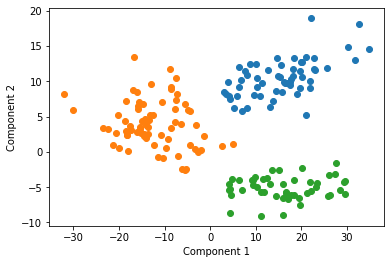

In [510]:
a2=a*pca2.explained_variance_[:,None]
Y=X2.dot(np.transpose(a2))
import matplotlib.pyplot as plt
plt.scatter(Y[tr==0,0],Y[tr==0,1])
plt.scatter(Y[tr==1,0],Y[tr==1,1])
plt.scatter(Y[tr==2,0],Y[tr==2,1])
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.savefig('effective_pca.png')

In [24]:
import numpy as np
from sklearn.decomposition import PCA
m=13
pca2 = PCA(n_components=m)
pca2.fit(X)#[:,0:28])
print(pca2.explained_variance_ratio_**2)
#a=(pca2.components_*pca2.explained_variance_ratio_[:,None]**0.5)
#a=(pca2.components_)*(pca2.explained_variance_ratio_[:,None]**0.5)
a=(pca2.components_)#*(pca2.explained_variance_ratio_[:,None])
print(np.sum(pca2.components_*pca2.components_,axis=1))
print(np.sum(a*a,axis=1))
#print(pca2.components_)
X=X.dot(np.transpose(a))

[1.31035660e-01 3.68927682e-02 1.23735156e-02 4.99711877e-03
 4.30768239e-03 2.43623518e-03 1.79664024e-03 7.18641492e-04
 4.93796575e-04 3.72497370e-04 3.01659821e-04 1.68540782e-04
 6.32366721e-05]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [187]:

print(len(X[0,:]))
X=np.concatenate((X*(X>0),-X*(X<0)),axis=1)
from sklearn.decomposition import NMF
model = NMF(n_components=3, init='nndsvda')
W = model.fit_transform(X)
H = model.components_
print(len(H[0,:]))
H[:,0:m]=(H[:,0:m]>H[:,m:2*m])*H[:,0:m]
H[:,m:2*m]=(H[:,0:m]<H[:,m:2*m])*H[:,m:2*m]
model = NMF(n_components=3, init='custom')
W = model.fit_transform(X,W=W,H=H)
H = model.components_

13
26


In [184]:
print(np.sqrt(sum(W*W)))
W=W*sum(W)/sum(W*W)
amx=np.argmax(W,axis=1)

[2.43531491 5.22310743 5.31979444]


In [99]:
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi

In [7]:
tr=data['target']

In [352]:
amx=np.argmax(W,axis=1)
amxx=amx
#amxx=amxx-(amxx==1)+(amxx==0)
#amxx=amxx+(amxx==1)-(amxx==2)
#amxx=(amxx-1)%3
amxx=amxx-1
amxx+=(amxx==-1)*3
#amxx
print(amx)
print(sum(amxx==tr))
print(len(tr))

AxisError: axis 1 is out of bounds for array of dimension 1

In [86]:
W=W/np.sqrt(np.sum(W*W,axis=1))[:,None]
Y=W.dot(np.transpose(W))
print(Y)

[[1.         0.97071257 0.9985286  ... 0.15830428 0.16129029 0.09934261]
 [0.97071257 1.         0.98231213 ... 0.15366796 0.15656651 0.09643312]
 [0.9985286  0.98231213 1.         ... 0.15807135 0.16105296 0.09919643]
 ...
 [0.15830428 0.15366796 0.15807135 ... 1.         0.99999543 0.9982324 ]
 [0.16129029 0.15656651 0.16105296 ... 0.99999543 1.         0.99804806]
 [0.09934261 0.09643312 0.09919643 ... 0.9982324  0.99804806 1.        ]]


In [90]:
model = NMF(n_components=3, init='nndsvda')
W = model.fit_transform(Y)
H = model.components_

In [94]:
W=W*sum(W)/sum(W*W)
amx=np.argmax(W,axis=1)
amxx=amx
#amxx=amxx-(amxx==1)+(amxx==0)
#amxx=(amxx-1)%3
amxx=amxx-(amxx==2)+(amxx==1)
#amxx
print(amx)
print(sum(amxx==tr))
print(len(tr))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 1 2 2 2 2 2 2 2 2 2 2 2 0
 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 0 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
171
178


In [86]:
N=178
dis=np.zeros((N,N))
hs=[]
ms=[]
for i in range(13):
    ms.append([])
for i in range(N):
    for j in range(N):
        dis[i,j]=(sum((X[i,0:13]-X[j,0:13])**2))**0.5
        #dis[i,j]=(sum(abs(X[i,0:13]-X[j,0:13])))
        hs.append(dis[i,j])
        for k in range(13):
            ms[k].append(abs(X[i,k]-X[j,k])**2)
import matplotlib.pyplot as plt
#plt.hist(hs,bins=40)
#plt.show()
#for i in range(13):
#    plt.hist(ms[i],bins=20)
#    plt.show()

In [11]:
for i in range(13):
    print(np.mean(np.array(ms[i])))
np.mean(dis*dis) 

1.9999999999999991
1.9999999999999998
2.0000000000000013
2.0
1.9999999999999998
2.0000000000000013
2.000000000000001
1.9999999999999998
2.000000000000001
2.0000000000000004
2.0000000000000004
1.9999999999999993
2.0000000000000013


26.000000000000004

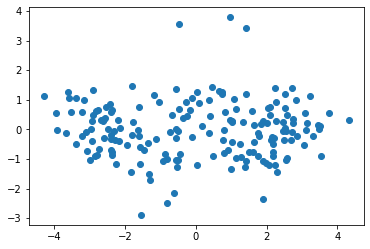

In [1181]:
plt.scatter(X[:,0],X[:,3])
plt.show()

In [87]:
Z=dis<4.1
kt=np.zeros(178)
kt[0]=1
for i in range(200):
    kt=Z.dot(kt)>0
print(sum(kt))
print(np.argmin(kt))

178
0


In [1318]:

#Z=np.exp(-dis/100000)
#Z=np.max(dis)-dis
#Z=(dis<2)*np.exp(-dis**2/5)
#Z=np.exp(-dis**2/25)
#Z=4.05-dis
#Z[Z<0]=0
#Z=np.exp(-dis**2/6)
#sig=np.mean(dis,axis=1)
Z=np.exp((-dis**2/sig)/sig[:,None])
#Z=0.8*np.mean(dis,axis=1)-dis
#Z[Z<0]=0
#Z[Z>0]=1
#Z=np.exp(-dis/200)
#print(Z)

In [88]:

Z=X[:,0:13].dot(np.transpose(X[:,0:13]))
Z=4.1-dis
#Z=(13-dis)
#print(D)
#Zz=-Z
#Zz[Zz<0]=0
Z[Z<0]=0
#Z=Z*Z#+Zz.dot(Zz)
D=np.sqrt(np.diagonal(Z))

Z=Z/D
Z=Z/D[:,None]
#Z[Z<0]=0
#Z=dis
#Z=(dis**2).dot(dis**2)
#np.fill_diagonal(Z,0)
print(Z)
from walk_likelihood import *
Ws=sum(Z)
#Ws[:]=178
#print(Ws)
#Ws[:]=1
ket=walk_likelihood_variable_comms_with_nmf(Z,Ws,lm=0)
#ket=walk_likelihood_variable_comms_with_nmf(Z,Ws,lm=0)
#ket=np.zeros((178,3))
#ket[range(178),tr]=1

#ket=walk_likelihood_variable_comms_rand(Z,Ws,twice=1)
#ket=walk_likelihood_variable_comms_rand(Z,Ws,lm=0)#,ket=ket)

[[1.         0.14694263 0.26180294 ... 0.         0.         0.        ]
 [0.14694263 1.         0.         ... 0.         0.         0.        ]
 [0.26180294 0.         1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.55458101 0.17255725]
 [0.         0.         0.         ... 0.55458101 1.         0.1892009 ]
 [0.         0.         0.         ... 0.17255725 0.1892009  1.        ]]
3
3
3
3


In [90]:
amx=np.argmax(ket,axis=1)
amxx=amx
#amxx=amxx-3*(amxx==3)+(amxx==0)-(amxx==2)+(amxx==1)
#amxx=amxx-(amxx==1)+(amxx==0)
#amxx=amxx+(amxx==1)-(amxx==2)
#amxx=amxx+2*(amxx==0)-2*(amxx==2)
#amxx=amxx-2*(amxx==3)-3*(amxx==4)
#amxx=(amxx+1)%3
#amxx=(amxx-1)%3
#amxx=amxx-1
#amxx+=(amxx==-1)*3
#amxx
print(amxx)
print(sum(amxx==tr))
#print((tr))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0
 1 1 1 1 0 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 0 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 2 1 1 0 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
169


In [1188]:
for i in range(3):
    a=np.array(range(178))[amx==i]
    print(np.mean(dis[a,:][:,a]*dis[a,:][:,a]))

17.28966183859767
12.459556201347825
12.870490356425861


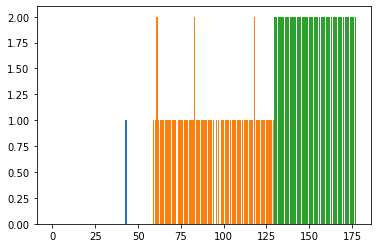

In [1014]:
59+71+48
plt.bar(range(59),amxx[tr==0])
plt.bar(range(59,59+71),amxx[tr==1])
plt.bar(range(59+71,59+71+48),amxx[tr==2])
plt.show()

In [399]:
sum(amxx==amxxc)

178

In [391]:
amxxc=amxx

In [136]:
F=H[:,0:13]-H[:,13:26]
F=F/np.diagonal(np.sqrt(np.dot(F,np.transpose(F))))[:,None]
print(np.dot(F,np.transpose(F)))

[[ 1.         -0.70790011 -0.35808105]
 [-0.70790011  1.         -0.40148911]
 [-0.35808105 -0.40148911  1.        ]]


<ipython-input-136-7d4655d25cdf>:2: RuntimeWarning: invalid value encountered in sqrt
  F=F/np.diagonal(np.sqrt(np.dot(F,np.transpose(F))))[:,None]


In [122]:
import pandas as pd
df = pd.read_csv("Merged data for clustering_V2.csv")
df = df.drop(columns = ['prior_mi','prior_pci','prior_cabg','prior_stroke','date_time_zero','kaplan_meier_mi_date','kaplan_meier_hf_date','kaplan_meier_death_date','date_alive','study_id','withdrawn','study_cat','nstemi_type'])
A = df.corr()
from pylab import *
figure(1)
imshow(A,interpolation = 'nearest')

KeyError: "['prior_mi' 'prior_pci' 'prior_cabg' 'prior_stroke' 'date_time_zero'\n 'kaplan_meier_mi_date' 'kaplan_meier_hf_date' 'kaplan_meier_death_date'\n 'date_alive' 'study_id' 'withdrawn' 'study_cat' 'nstemi_type'] not found in axis"

In [78]:
import pandas as pd
df = pd.read_csv("cars.csv")
df2=df.copy()
df2=df2.drop(df.columns[0:3],axis=1)
a=df2.to_numpy()
a=a[:,0:-1]
#print(a)

In [79]:
import numpy as np
mu=np.mean(a,axis=0)
len(mu)
import numpy as np 
a=(a-mu)/np.std(a,axis=0)
print(np.std(a,axis=0))

[1. 1. 1. 1. 1.]


In [80]:
import numpy as np
from sklearn.decomposition import PCA
pca2 = PCA(n_components=5)
pca2.fit(a)#[:,0:28])
print(pca2.explained_variance_ratio_**2)
#a=(pca2.components_*pca2.explained_variance_ratio_[:,None]**0.5)
#a=(pca2.components_)*(pca2.explained_variance_ratio_[:,None]**0.5)
b=(pca2.components_)#*(pca2.explained_variance_ratio_[:,None])
a=a.dot(np.transpose(b))

[6.88779050e-01 1.68485697e-02 4.88455096e-04 1.96979313e-04
 1.70971657e-05]


In [107]:
Y=np.dot(a,np.transpose(a))
Y=-2*Y+np.diagonal(Y)+np.diagonal(Y)[:,None]
Y=np.sqrt(Y)
print(len(Y[:,0]))
print(Y)

38
[[0.         1.15514873 1.90435458 ... 4.41438433 4.4541926  6.40487869]
 [1.15514873 0.         1.55856748 ... 4.53352168 4.57040332 6.39869916]
 [1.90435458 1.55856748 0.         ... 3.08325852 3.12650972 4.87563791]
 ...
 [4.41438433 4.53352168 3.08325852 ... 0.         0.66652123 2.32722437]
 [4.4541926  4.57040332 3.12650972 ... 0.66652123 0.         2.4433169 ]
 [6.40487869 6.39869916 4.87563791 ... 2.32722437 2.4433169  0.        ]]


In [108]:
#Y[Y<0]=0
#Z=Z*Z#+Zz.dot(Zz)
#D=np.sqrt(np.diagonal(Y))

#Y=Y/D
#Y=Y/D[:,None]
#Z[Z<0]=0
#Z=dis
#Z=(dis**2).dot(dis**2)
#np.fill_diagonal(Y,0)
Y=np.exp(-0.0000001*Y)
#print(Y)
from walk_likelihood import *
Ws=sum(Y)
#Ws[:]=178
#print(Ws)
#Ws[:]=1
#ket=walk_likelihood_variable_comms_with_nmf(Y,Ws,lm=0)
#ket=walk_likelihood_variable_comms_with_nmf(Z,Ws,lm=0)
#ket=np.zeros((178,3))
#ket[range(178),tr]=1

#ket=walk_likelihood_variable_comms_rand(Z,Ws,twice=1)
ket=walk_likelihood_variable_comms_rand(Y,Ws,lm=0)#,ket=ket)

0
2
3
1
3
3
2
3
3
3


In [109]:
amx=np.argmax(ket,axis=1)
print((amx))

[0 0 0 0 1 1 1 1 2 2 2 2 0 2 0 0 0 0 0 0 1 2 1 1 1 1 1 2 2 2 1 1 1 1 1 2 2
 1]


In [111]:
a=np.zeros(10)
print(a)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
